# Runoff anomaly
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 29-01-2025*<br>

**Introduction**<br>

This notebook computes the runoff anomaly in the year 2024 based on the results of the GloFAS4 historical run. The reference period used as climatology spans from 1991 to 2020.

**Output**<br>
A NetCDF of runoff anomaly.

In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from datetime import datetime

## Configuration

In [2]:
VAR = 'runoff'

# inputs
PATH_IN = Path('../data/GloFAS')
CLIMA_FILE = PATH_IN / VAR / f'{VAR}_avg_1991-2020.nc'
YEAR_FILE = PATH_IN / VAR / f'{VAR}_avg_2024.nc'
# UPAREA_FILE = PATH_IN / 'static_maps' / 'upArea.nc'

# output
PATH_OUT = Path('../results') / VAR
PATH_PLOT = PATH_OUT / 'plots'
PATH_PLOT.mkdir(parents=True, exist_ok=True)

In [3]:
map_variables = {
    'runoff': 'rowe',
    'discharge': 'dis24'
}

var_shortname = map_variables[VAR]

## Data

In [4]:
# load climatology: average period 1991-2020
climatology = xr.open_dataset(CLIMA_FILE)[var_shortname]
climatology.close()

# load year of analysis: 2024
data = xr.open_dataset(YEAR_FILE)[var_shortname]
data.close()

## Anomaly

In [5]:
# compute annual anomaly
anomaly = (data - climatology) * 365 # mm/yr

# correct name and coordinates
anomaly.name = VAR
anomaly = anomaly.drop_vars('surface', errors='ignore')

# convert to rioxarray
anomaly = anomaly.rio.write_crs('EPSG:4326')

# add attributes
anomaly.attrs['long_name'] = 'runoff anomaly'
anomaly.attrs['units'] = 'mm/yr'
anomaly.attrs['climatology'] = '1991-2020'
anomaly.attrs['source'] = 'GloFASv4'
anomaly.attrs['crs'] = 'epsg:4326'
anomaly.attrs['author'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>'
anomaly.attrs['institution'] = 'Joint Research Centre - European Commission'
anomaly.attrs['history'] = 'Created {0}'.format(datetime.now().strftime("%B %d %Y %H:%M:%S"))

### Plot

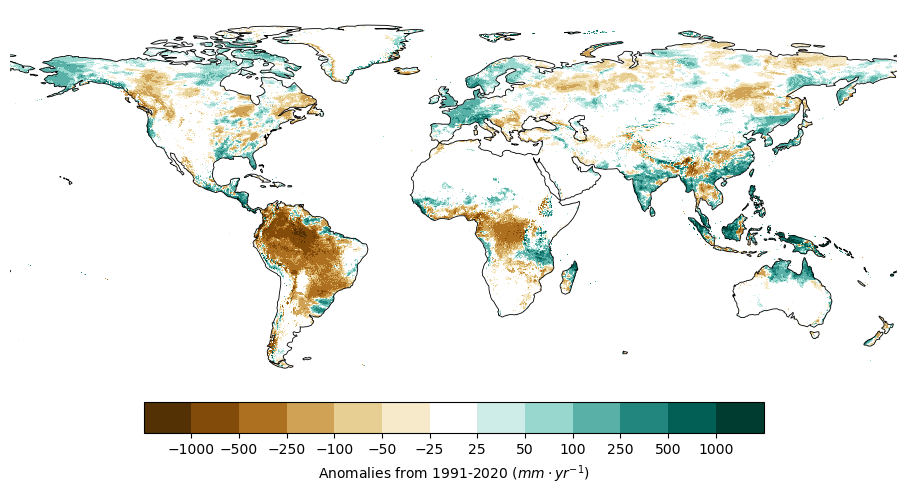

In [8]:
# Define the colormap and normalization
boundaries = [-1e4, -1e3, -500, -250, -100, -50, -25, 25, 50, 100, 250, 500, 1e3, 1e4]
cmap = plt.cm.BrBG
ncolors = len(boundaries) - 1 # Include the extended region colors
colors = cmap(np.linspace(0, 1, ncolors))  # Extract equally spaced colors
colors[int(ncolors / 2), :] = [1., 1., 1., 1.]
cmap_discrete = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries, ncolors, extend='neither')

fig, ax = plt.subplots(figsize=(16, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot coastlines for continents
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=.6)

# Plot anomaly with the fixed discrete colormap
anomaly.plot(
    ax=ax,
    cmap=cmap_discrete,
    norm=norm,
    cbar_kwargs={
        'shrink': .5,
        'orientation': 'horizontal', 
        'pad': 0.05, 
        'label': r'Anomalies from 1991-2020 ($mm \cdot yr^{-1}$)',
        'ticks': boundaries[1:-1],  # Avoid extreme values in ticks
        # 'extend': 'both',
    }
)

ax.set_title(None)
ax.axis('off')

plt.savefig(PATH_PLOT / 'map_anomaly.jpg', dpi=300, bbox_inches='tight')

### Export

In [7]:
# export
output_file = PATH_OUT / f'{VAR}_anomaly.nc'
anomaly.to_netcdf(output_file)
print(f'Map of river discharge anomaly in 2024 saved in:\t{output_file}')

Map of river discharge anomaly in 2024 saved in:	..\results\runoff\runoff_anomaly.nc
